In [ ]:
import os
import torch
import torch.nn as nn
import math

from functools import partial
from ray import tune, air
from ray.tune import CLIReporter, RunConfig
from ray.tune.tuner import Tuner

import datasets
import models
import train
import utils
import search_spaces

from adaptive_time_frequency import adstft_compute
from main import run_experiment
from produce_figures import produce_data_example_plot
from datasets import GaussPulseDatasetTimeFrequency

In [31]:
num_samples = 1
max_epochs = 1000
experiment_name = "time_frequency"
ray_root_dir = os.path.abspath("ray_results")
data_dir = os.path.abspath("data/time_frequency")

search_space = search_spaces.time_frequency(max_epochs)

reporter = CLIReporter(
    metric_columns=["loss", "valid_loss", "valid_acc", "best_valid_acc", "lambd_est", "training_iteration"],
    parameter_columns=["init_lambd", "trainable", "speaker_id", "model_name"],
    max_column_length=10
)


In [32]:
run_experiment_fn = partial(run_experiment, data_dir=data_dir)

trainable_with_resources = run_experiment_fn

tuner = Tuner(
    trainable_with_resources,
    param_space=search_space,
    run_config=RunConfig(
        name=experiment_name,
        storage_path=ray_root_dir,
        verbose=1,
        progress_reporter=reporter,
    ),
    tune_config=tune.TuneConfig(num_samples=num_samples),
)

results = tuner.fit()

2025-04-23 08:46:23,239	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2025-04-23 08:46:23,242	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2025-04-23 08:46:23 (running for 00:00:00.16)
Using FIFO scheduling algorithm.
Logical resource usage: 6.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-23_07-25-20_359135_18492/artifacts/2025-04-23_08-46-23/time_frequency/driver_artifacts
Number of trials: 6/6 (6 PENDING)


== Status ==
Current time: 2025-04-23 08:46:28 (running for 00:00:05.17)
Using FIFO scheduling algorithm.
Logical resource usage: 6.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-23_07-25-20_359135_18492/artifacts/2025-04-23_08-46-23/time_frequency/driver_artifacts
Number of trials: 6/6 (6 RUNNING)


== Status ==
Current time: 2025-04-23 08:46:33 (running for 00:00:10.21)
Using FIFO scheduling algorithm.
Logical resource usage: 6.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-23_07-25-20_359135_18492/artifacts/2025-04-23_08-46-23/time_frequency/driver_artifacts
Number of trials: 6/6 (6 RUNNING)


== Status ==
Current time: 2025-04-23 08:46:38 (running fo

2025-04-23 08:47:45,061	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-04-23 08:47:45,144	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/viktor/Documents/Spectral/differentiable-mel-spectrogram/ray_results/time_frequency' in 0.0630s.


== Status ==
Current time: 2025-04-23 08:47:45 (running for 00:01:21.91)
Using FIFO scheduling algorithm.
Logical resource usage: 6.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-23_07-25-20_359135_18492/artifacts/2025-04-23_08-46-23/time_frequency/driver_artifacts
Number of trials: 6/6 (6 RUNNING)




2025-04-23 08:47:46,245	INFO tune.py:1041 -- Total run time: 83.01 seconds (81.84 seconds for the tuning loop).
2025-04-23 08:47:46,246	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/Users/viktor/Documents/Spectral/differentiable-mel-spectrogram/ray_results/time_frequency", trainable=...)


In [33]:
best_result = results.get_best_result(metric="best_valid_acc", mode="max")

print(best_result.config)

print(best_result.metrics["best_valid_acc"])

{'model_name': 'linear_net', 'hop_length': 1, 'optimized': False, 'normalize_window': False, 'optimizer_name': 'sgd', 'lr_model': 0.001, 'lr_tf': 1, 'batch_size': 128, 'trainable': False, 'max_epochs': 1000, 'patience': 100, 'device': device(type='cpu'), 'n_points': 128, 'noise_std': 0.5, 'init_lambd': 6.38, 'n_samples': 5000, 'sigma_ref': 6.38, 'dataset_name': 'time_frequency', 'center_offset': False}
0.98046875


NameError: name 'experiment_path' is not defined

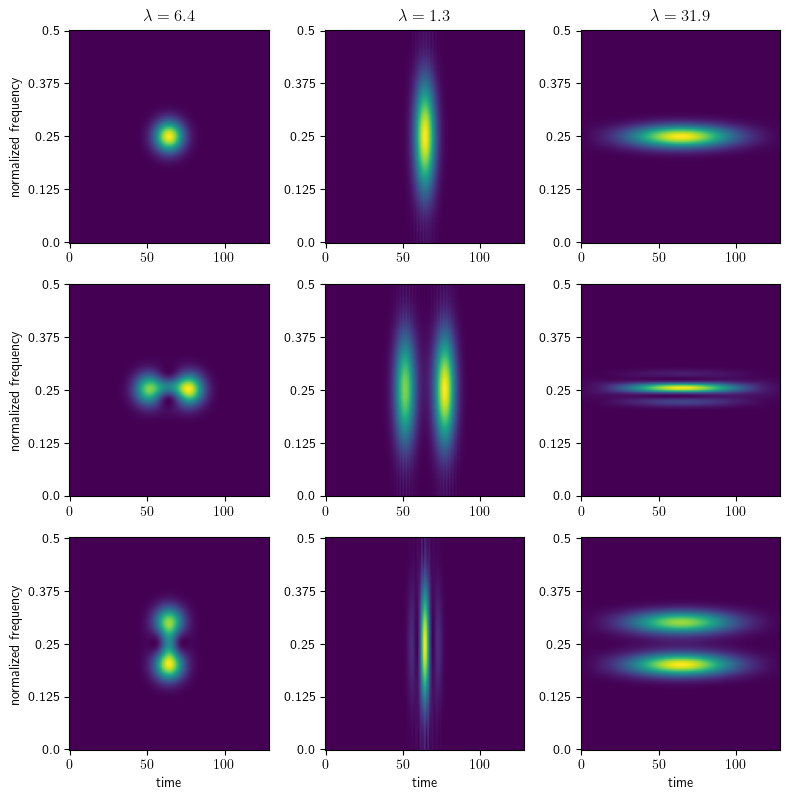

In [49]:
produce_data_example_plot()

Testing of adaptive STFT

In [ ]:
batch_size = 4
signal_length = 1024
support = 256
stride = 128
F = int(1 + support / 2)
T = int(1 + (signal_length - (support - 1) - 1) // stride)

sigma_ref = torch.tensor(6.38)
dataset = datasets.GaussPulseDatasetTimeFrequency(
    sigma=sigma_ref,
    n_points=signal_length,
    noise_std=torch.tensor(0.05),
    n_samples=batch_size,
    demo=True
)

x = dataset.xs[:batch_size].float().to('cuda' if torch.cuda.is_available() else 'cpu')

stride_param = torch.tensor([stride], dtype=torch.float32, device=x.device) ## Fixed stride

## T adaptive
#win_length_param = nn.Parameter(torch.full((1, T), support/2, device=x.device), requires_grad=True)
win_length_param = nn.Parameter(
    torch.linspace(support/8, support*0.95, T).view(1, T).to(x.device),
    requires_grad=True
)

## F adaptive
#win_length_param = nn.Parameter(
#    torch.linspace(support/4, support*0.8, F).view(F, 1),
#    requires_grad=True
#)

## TF adaptive
#win_length_param = nn.Parameter(torch.full((F, T), support/2, device=x.device), requires_grad=True)

spec, stft = adstft_compute(
    x=x,
    win_length_param=win_length_param,
    strides_param=stride_param,
    N=support,
    F=F,
    T=T,
    pow=1.0
)

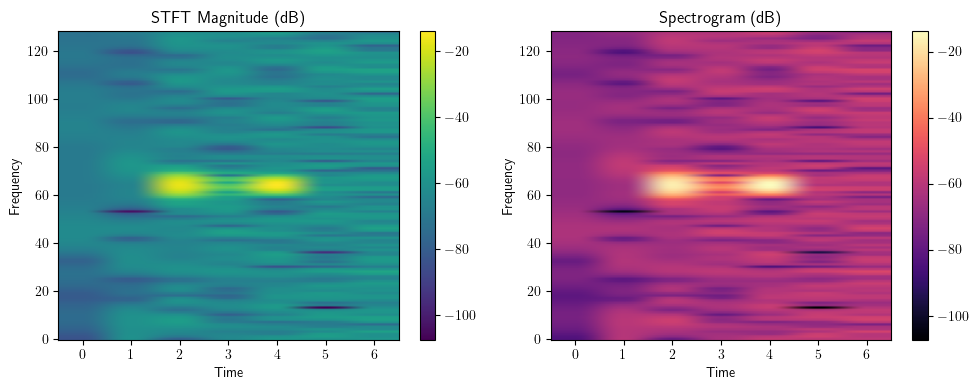

In [63]:
import matplotlib.pyplot as plt
import numpy as np

index = 0

stft_np = np.abs(stft[index].cpu().detach().numpy())
spec_np = spec[index].cpu().detach().numpy()

stft_db = 20 * np.log10(stft_np + 1e-10)
spec_db = 20 * np.log10(spec_np + 1e-10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

im1 = ax1.imshow(stft_db, aspect='auto', origin='lower', cmap='viridis')
ax1.set_title('STFT Magnitude (dB)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Frequency')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(spec_db, aspect='auto', origin='lower', cmap='magma')
ax2.set_title('Spectrogram (dB)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Frequency')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()